In [53]:
import quandl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

results=pd.read_csv('results.csv')

In [33]:
results.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'index', 'Short_ticker', 'Name', 'Ticker',
       'Date', 'Event Type', 'Adjusted Trading Date', 'trade_entry',
       'trade_exit', 'stock_price_entry', 'stock_price_exit', 'year_entry',
       'year_exit', 'straddle_entry_mid', 'straddle_exit_mid', 'straddle_pnl',
       'straddle_entry_vol', 'straddle_entry_bid', 'straddle_entry_offer',
       'straddle_entry_gamma', 'straddle_entry_vega', 'straddle_entry_theta',
       'straddle_entry_delta', 'straddle_entry_strike', 'IV_25c', 'IV_25p',
       'IV_10c', 'IV_10p', 'IV_50c', 'skew_25', 'skew_25_decile', 'kurt_25',
       'kurt_25_decile'],
      dtype='object')

In [34]:
data=results[['Short_ticker','Date','trade_entry',
        'stock_price_entry',  'year_entry',
      'straddle_entry_mid',  'straddle_pnl',
       'straddle_entry_vol', 'straddle_entry_bid', 'straddle_entry_offer',
       'straddle_entry_gamma', 'straddle_entry_vega', 'straddle_entry_theta',
       'straddle_entry_delta', 'straddle_entry_strike']]

In [35]:
data.dropna(inplace=True)

In [36]:
data

,Short_ticker,Date,trade_entry,stock_price_entry,year_entry,straddle_entry_mid,straddle_pnl,straddle_entry_vol,straddle_entry_bid,straddle_entry_offer,straddle_entry_gamma,straddle_entry_vega,straddle_entry_theta,straddle_entry_delta,straddle_entry_strike
0,A,2018-02-14 16:05:00,2018-02-14,69.70000,2018,1.1825,120.507400,0.570426,2.31,2.42,0.270293,4.104012,-213.4981,-0.062831,70000.0
2,A,2018-08-14 16:05:00,2018-08-14,66.75000,2018,2.2750,408.791209,0.929385,4.30,4.80,0.141360,4.809313,-271.7235,-0.070716,67500.0
11,A,2020-08-18 16:05:00,2020-08-18,97.86000,2020,2.3250,784.946237,0.656911,4.45,4.85,0.136363,7.049640,-281.6094,0.073169,97500.0
18,A,2022-08-16 16:05:00,2022-08-16,132.77000,2022,2.9000,-271.551724,0.570118,5.60,6.00,0.111469,9.196867,-318.3868,-0.230628,135000.0
25,AA,2018-01-17 16:10:00,2018-01-17,56.99000,2018,1.5250,-336.065574,0.906141,2.95,3.15,0.208610,3.364442,-278.0769,0.025555,57000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19440,ZS,2021-05-25 16:05:00,2021-05-25,172.74001,2021,6.9500,-589.208633,1.113478,13.45,14.35,0.045647,12.470478,-844.3345,0.051250,172500.0
19442,ZS,2021-11-30 16:05:00,2021-11-30,346.97000,2021,16.6500,96.246246,1.326364,31.75,34.85,0.019095,25.072080,-2022.0890,0.037854,347500.0
19460,ZTS,2019-11-07 07:00:00,2019-11-06,121.47000,2019,2.4125,689.119171,0.671742,4.25,5.40,0.131411,7.135706,-437.3842,0.083227,121000.0
19462,ZTS,2020-05-06 07:00:00,2020-05-05,131.30000,2020,2.9000,228.448276,0.610891,5.20,6.40,0.109433,9.475863,-352.0016,0.055124,131000.0


In [37]:

def get_previous_quarter(date_str):
    # Convert the input string to a datetime object
    date = pd.Timestamp(date_str)
    
    # Get the current quarter of the datetime
    current_quarter = date.quarter
    
    # Determine the previous quarter and adjust the year if needed
    if current_quarter == 1:
        previous_quarter = 4
        year = date.year - 1
    else:
        previous_quarter = current_quarter - 1
        year = date.year
    
    # Return the result as "Q<quarter> <year>"
    return f"Q{previous_quarter} {year}"

data['quarter']=data['Date'].apply(lambda x: get_previous_quarter(x))
data['quarter_with_ticker']=data['quarter']+data['Short_ticker']
data.drop_duplicates(subset='quarter_with_ticker',inplace=True)

In [38]:
data

,Short_ticker,Date,trade_entry,stock_price_entry,year_entry,straddle_entry_mid,straddle_pnl,straddle_entry_vol,straddle_entry_bid,straddle_entry_offer,straddle_entry_gamma,straddle_entry_vega,straddle_entry_theta,straddle_entry_delta,straddle_entry_strike,quarter,quarter_with_ticker
0,A,2018-02-14 16:05:00,2018-02-14,69.70000,2018,1.1825,120.507400,0.570426,2.31,2.42,0.270293,4.104012,-213.4981,-0.062831,70000.0,Q4 2017,Q4 2017A
2,A,2018-08-14 16:05:00,2018-08-14,66.75000,2018,2.2750,408.791209,0.929385,4.30,4.80,0.141360,4.809313,-271.7235,-0.070716,67500.0,Q2 2018,Q2 2018A
11,A,2020-08-18 16:05:00,2020-08-18,97.86000,2020,2.3250,784.946237,0.656911,4.45,4.85,0.136363,7.049640,-281.6094,0.073169,97500.0,Q2 2020,Q2 2020A
18,A,2022-08-16 16:05:00,2022-08-16,132.77000,2022,2.9000,-271.551724,0.570118,5.60,6.00,0.111469,9.196867,-318.3868,-0.230628,135000.0,Q2 2022,Q2 2022A
25,AA,2018-01-17 16:10:00,2018-01-17,56.99000,2018,1.5250,-336.065574,0.906141,2.95,3.15,0.208610,3.364442,-278.0769,0.025555,57000.0,Q4 2017,Q4 2017AA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19440,ZS,2021-05-25 16:05:00,2021-05-25,172.74001,2021,6.9500,-589.208633,1.113478,13.45,14.35,0.045647,12.470478,-844.3345,0.051250,172500.0,Q1 2021,Q1 2021ZS
19442,ZS,2021-11-30 16:05:00,2021-11-30,346.97000,2021,16.6500,96.246246,1.326364,31.75,34.85,0.019095,25.072080,-2022.0890,0.037854,347500.0,Q3 2021,Q3 2021ZS
19460,ZTS,2019-11-07 07:00:00,2019-11-06,121.47000,2019,2.4125,689.119171,0.671742,4.25,5.40,0.131411,7.135706,-437.3842,0.083227,121000.0,Q3 2019,Q3 2019ZTS
19462,ZTS,2020-05-06 07:00:00,2020-05-05,131.30000,2020,2.9000,228.448276,0.610891,5.20,6.40,0.109433,9.475863,-352.0016,0.055124,131000.0,Q1 2020,Q1 2020ZTS


In [39]:
fundamental_data=pd.read_csv('ZACKSFC_updated.csv')
fundamental_data

,ticker,per_end_date,per_fisc_year,per_fisc_qtr,zacks_sector_code,zacks_x_ind_code,zacks_metrics_ind_code,tot_revnu,cost_good_sold,gross_profit,...,cash_flow_fin_activity,incr_decr_cash,beg_cash,end_cash,stock_based_compsn,comm_stock_div_paid,wavg_shares_out,wavg_shares_out_diluted,eps_basic_net,eps_diluted_net
0,CABO,6/30/2023,2023,2,2,33,27.0,424.024,112.804,311.220,...,-186.2370,-54.4160,215.1500,160.7340,11.5840,-32.8370,5.6608,6.0710,9.7600,9.3600
1,CABO,3/31/2023,2023,1,2,33,27.0,421.894,112.161,309.733,...,-73.4910,-12.4180,215.1500,202.7320,5.5850,-16.4980,5.7187,6.1286,10.0400,9.6200
2,CABO,12/31/2022,2022,4,2,33,27.0,425.514,112.615,312.899,...,-463.4250,-173.6520,388.8020,215.1500,22.5140,-66.2550,5.8921,6.3141,-12.5000,-11.4300
3,CABO,9/30/2022,2022,3,2,33,27.0,424.718,120.487,304.231,...,-387.3700,-133.0830,388.8020,255.7190,17.0160,-49.7510,5.8367,6.2613,12.1000,11.5300
4,CABO,6/30/2022,2022,2,2,33,27.0,429.085,118.393,310.692,...,-246.7380,-108.8240,388.8020,279.9780,11.1560,-33.0880,5.9465,6.3696,11.6400,11.1100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52332,STN,12/31/2020,2020,4,16,277,27.0,3531.020,2089.901,1441.118,...,-308.0059,60.3172,152.2860,212.6032,NaN,-50.7620,111.5540,111.9490,1.1421,1.1421
52333,STN,12/31/2019,2019,4,16,277,27.0,3637.853,2124.323,1513.530,...,-215.5296,14.1677,139.5667,153.7344,NaN,-48.2304,111.5500,111.5500,1.3113,1.3113
52334,STN,12/31/2018,2018,4,16,277,27.0,3304.952,1904.525,1400.427,...,13.8870,-41.8925,184.7742,142.8818,NaN,-47.2930,112.8571,112.8571,0.3240,0.3240
52335,STN,12/31/2017,2017,4,16,277,27.0,3965.073,2555.031,1410.042,...,-216.8405,22.0620,162.6883,184.7503,7.3283,-42.8127,113.9900,114.3500,0.6557,0.6557


In [40]:
def current_quarter(date_str):
    # Convert the input string to a datetime object
    date = pd.Timestamp(date_str)
    
    # Get the current quarter of the datetime
    current_quarter = date.quarter
    
    # Determine the previous quarter and adjust the year if needed
    year = date.year
    
    # Return the result as "Q<quarter> <year>"
    return f"Q{current_quarter} {year}"
fundamental_data['quarter']=fundamental_data['per_end_date'].apply(lambda x: current_quarter(x))
fundamental_data['quarter_with_ticker']=fundamental_data['quarter']+fundamental_data['ticker']
fundamental_data.drop_duplicates(subset='quarter_with_ticker',inplace=True)

In [41]:
merged_df = pd.merge(data,fundamental_data, left_on='quarter_with_ticker' , right_on='quarter_with_ticker', how='left')

# Display the merged dataframe
print(merged_df)

     Short_ticker                 Date trade_entry  stock_price_entry  \
0               A  2018-02-14 16:05:00  2018-02-14           69.70000   
1               A  2018-08-14 16:05:00  2018-08-14           66.75000   
2               A  2020-08-18 16:05:00  2020-08-18           97.86000   
3               A  2022-08-16 16:05:00  2022-08-16          132.77000   
4              AA  2018-01-17 16:10:00  2018-01-17           56.99000   
...           ...                  ...         ...                ...   
1580           ZS  2021-05-25 16:05:00  2021-05-25          172.74001   
1581           ZS  2021-11-30 16:05:00  2021-11-30          346.97000   
1582          ZTS  2019-11-07 07:00:00  2019-11-06          121.47000   
1583          ZTS  2020-05-06 07:00:00  2020-05-05          131.30000   
1584          ZTS  2020-08-06 07:00:00  2020-08-05          157.72000   

      year_entry  straddle_entry_mid  straddle_pnl  straddle_entry_vol  \
0           2018              1.1825    120.50740

In [42]:
df = pd.DataFrame(data)

# Replace NaN values with mean for numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Replace NaN values with the most frequent value for non-numerical columns
non_numerical_cols = df.select_dtypes(exclude=['number']).columns
for col in non_numerical_cols:
    most_frequent_value = df[col].mode()[0]
    if most_frequent_value == np.nan:
        most_frequent_value = df[col].mode()[1]
    df[col] = df[col].fillna(most_frequent_value)


In [43]:
df['class']=[1 if x>0 else 0 for x in df['straddle_pnl']]

In [44]:
df.head(2)

,Short_ticker,Date,trade_entry,stock_price_entry,year_entry,straddle_entry_mid,straddle_pnl,straddle_entry_vol,straddle_entry_bid,straddle_entry_offer,straddle_entry_gamma,straddle_entry_vega,straddle_entry_theta,straddle_entry_delta,straddle_entry_strike,quarter,quarter_with_ticker,class
0,A,2018-02-14 16:05:00,2018-02-14,69.70,2018,1.1825,120.507400,0.570426,2.31,2.42,0.270293,4.104012,-213.4981,-0.062831,70000.0,Q4 2017,Q4 2017A,1
2,A,2018-08-14 16:05:00,2018-08-14,66.75,2018,2.2750,408.791209,0.929385,4.30,4.80,0.141360,4.809313,-271.7235,-0.070716,67500.0,Q2 2018,Q2 2018A,1


Accuracy: 0.5609243697478992
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.37      0.39       180
           1       0.64      0.68      0.66       296

    accuracy                           0.56       476
   macro avg       0.53      0.52      0.52       476
weighted avg       0.55      0.56      0.56       476

Confusion Matrix:
[[ 67 113]
 [ 96 200]]


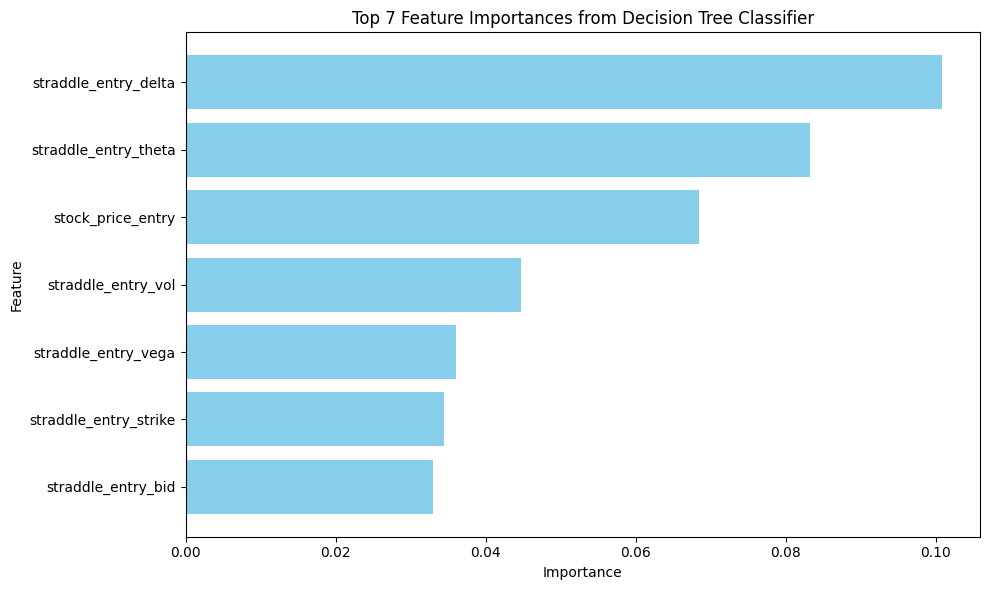

In [80]:

# Convert categorical columns to numeric using one-hot encoding
df_encoded = pd.get_dummies(df, columns=non_numerical_cols, drop_first=True)

# Split the features and target
X = df_encoded.drop(columns=['class', 'straddle_pnl'])
y = df_encoded['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Decision Tree classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Train the model
dt_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")
print(f"Confusion Matrix:\n{conf_matrix}")
# Get feature importances from the trained decision tree classifier
feature_importances = dt_clf.feature_importances_

# Get the names of the encoded features
encoded_feature_names = X.columns

# Construct a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': encoded_feature_names,
                                      'Importance': feature_importances})

# Sort the DataFrame by importance values in descending order and select the top 7 features
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(7)

# Plot feature importances for the top 7 features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 7 Feature Importances from Decision Tree Classifier')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.tight_layout()
plt.savefig('top_7_feature_importances.png')
plt.show()


In [46]:
# Get feature importances from the trained decision tree classifier
feature_importances = dt_clf.feature_importances_

# Get the names of the encoded features
encoded_feature_names = X.columns

# Construct a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': encoded_feature_names,
                                      'Importance': feature_importances})

# Sort the DataFrame by importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)



In [47]:
feature_importance_df.head(7)

,Feature,Importance
9,straddle_entry_delta,0.100849
8,straddle_entry_theta,0.083206
0,stock_price_entry,0.068500
3,straddle_entry_vol,0.044707
7,straddle_entry_vega,0.036087
10,straddle_entry_strike,0.034444
4,straddle_entry_bid,0.033005


In [55]:

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SGDClassifier with logistic regression loss
log_reg_sgd = SGDClassifier(loss='log_loss', random_state=42)

# Train the model
log_reg_sgd.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = log_reg_sgd.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")
print(f"Confusion Matrix:\n{conf_matrix}")


Accuracy: 0.6197478991596639
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.01      0.01       180
           1       0.62      0.99      0.76       296

    accuracy                           0.62       476
   macro avg       0.48      0.50      0.39       476
weighted avg       0.51      0.62      0.48       476

Confusion Matrix:
[[  1 179]
 [  2 294]]


In [57]:



# Define a range of k values
k_values = [1, 3, 5, 7, 9]

# Initialize dictionaries to store evaluation metrics for each k value
accuracy_scores = {}
classification_reports = {}
confusion_matrices = {}

for k in k_values:
    # Initialize the KNeighborsClassifier with the current k value
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Train the model
    knn.fit(X_train_scaled, y_train)
    
    # Make predictions on the test set
    y_pred = knn.predict(X_test_scaled)
    
    # Evaluate the model
    accuracy_scores[k] = accuracy_score(y_test, y_pred)
    classification_reports[k] = classification_report(y_test, y_pred)
    confusion_matrices[k] = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for each k value
for k in k_values:
    print(f"K = {k}")
    print(f"Accuracy: {accuracy_scores[k]}")
    print(f"Classification Report:\n{classification_reports[k]}")
    print(f"Confusion Matrix:\n{confusion_matrices[k]}\n")


K = 1
Accuracy: 0.41386554621848737
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.80      0.51       180
           1       0.60      0.18      0.28       296

    accuracy                           0.41       476
   macro avg       0.48      0.49      0.39       476
weighted avg       0.51      0.41      0.36       476

Confusion Matrix:
[[144  36]
 [243  53]]

K = 3
Accuracy: 0.3760504201680672
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.88      0.52       180
           1       0.49      0.07      0.12       296

    accuracy                           0.38       476
   macro avg       0.43      0.48      0.32       476
weighted avg       0.44      0.38      0.27       476

Confusion Matrix:
[[159  21]
 [276  20]]

K = 5
Accuracy: 0.4495798319327731
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.6

In [59]:

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")
print(f"Confusion Matrix:\n{conf_matrix}")


Accuracy: 0.6197478991596639
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.04      0.07       180
           1       0.62      0.97      0.76       296

    accuracy                           0.62       476
   macro avg       0.55      0.51      0.42       476
weighted avg       0.56      0.62      0.50       476

Confusion Matrix:
[[  7 173]
 [  8 288]]


In [61]:

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the MLPClassifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# Train the model
mlp_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = mlp_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")
print(f"Confusion Matrix:\n{conf_matrix}")


Accuracy: 0.6008403361344538
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.09      0.14       180
           1       0.62      0.91      0.74       296

    accuracy                           0.60       476
   macro avg       0.50      0.50      0.44       476
weighted avg       0.53      0.60      0.51       476

Confusion Matrix:
[[ 16 164]
 [ 26 270]]


In [63]:

# Initialize the AdaBoost classifier with a base estimator (DecisionTreeClassifier by default)
adaboost_classifier = AdaBoostClassifier(n_estimators=100, random_state=42)

# Train the model
adaboost_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = adaboost_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")
print(f"Confusion Matrix:\n{conf_matrix}")


Accuracy: 0.5819327731092437
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.17      0.23       180
           1       0.62      0.83      0.71       296

    accuracy                           0.58       476
   macro avg       0.50      0.50      0.47       476
weighted avg       0.53      0.58      0.53       476

Confusion Matrix:
[[ 30 150]
 [ 49 247]]


In [81]:

# Convert categorical columns to numeric using one-hot encoding
df_encoded = pd.get_dummies(df, columns=non_numerical_cols, drop_first=True)

# Split the features and target
X = df_encoded.drop(columns=['class', 'straddle_pnl'])
y = df_encoded['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Function to calculate initial and adjusted PnL
def calculate_pnls(model, X_test, y_test, y_pred):
    initial_pnl = df_encoded.loc[y_test.index, 'straddle_pnl'].sum()
    adjusted_pnl = (df_encoded.loc[y_test.index, 'straddle_pnl'] * (2 * y_pred - 1)).sum()
    return initial_pnl, adjusted_pnl

# Dictionary to store PnLs
pnls = {}

# Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
dt_initial_pnl, dt_adjusted_pnl = calculate_pnls(dt_clf, X_test, y_test, y_pred)
pnls['Decision Tree'] = [dt_initial_pnl, dt_adjusted_pnl]

# SGD Classifier
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
sgd_clf = SGDClassifier(loss='log_loss', random_state=42)
sgd_clf.fit(X_train_scaled, y_train)
y_pred = sgd_clf.predict(X_test_scaled)
sgd_initial_pnl, sgd_adjusted_pnl = calculate_pnls(sgd_clf, X_test, y_test, y_pred)
pnls['SGD Classifier'] = [sgd_initial_pnl, sgd_adjusted_pnl]

# K-Nearest Neighbors Classifier
knn_clf = KNeighborsClassifier(n_neighbors=9)
knn_clf.fit(X_train_scaled, y_train)
y_pred = knn_clf.predict(X_test_scaled)
knn_initial_pnl, knn_adjusted_pnl = calculate_pnls(knn_clf, X_test, y_test, y_pred)
pnls['KNN (k=9)'] = [knn_initial_pnl, knn_adjusted_pnl]

# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
rf_initial_pnl, rf_adjusted_pnl = calculate_pnls(rf_clf, X_test, y_test, y_pred)
pnls['Random Forest'] = [rf_initial_pnl, rf_adjusted_pnl]

# MLP Classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_clf.fit(X_train_scaled, y_train)
y_pred = mlp_clf.predict(X_test_scaled)
mlp_initial_pnl, mlp_adjusted_pnl = calculate_pnls(mlp_clf, X_test, y_test, y_pred)
pnls['MLP Classifier'] = [mlp_initial_pnl, mlp_adjusted_pnl]

# AdaBoost Classifier
ab_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
ab_clf.fit(X_train, y_train)
y_pred = ab_clf.predict(X_test)
ab_initial_pnl, ab_adjusted_pnl = calculate_pnls(ab_clf, X_test, y_test, y_pred)
pnls['AdaBoost'] = [ab_initial_pnl, ab_adjusted_pnl]

# Create a DataFrame to compare the PnLs
pnl_df = pd.DataFrame.from_dict(pnls, orient='index', columns=['Initial PnL', 'Adjusted PnL'])
pnl_df['Difference'] = pnl_df['Adjusted PnL'] - pnl_df['Initial PnL']

# Display the table
print(pnl_df)

# Save the table as a CSV file
pnl_df.to_csv('model_pnl_comparison.csv')


                Initial PnL  Adjusted PnL    Difference
Decision Tree  -2083.223301   8741.873670  10825.096971
SGD Classifier -2083.223301  -3958.494340  -1875.271040
KNN (k=9)      -2083.223301  -5991.761003  -3908.537703
Random Forest  -2083.223301   1422.390541   3505.613842
MLP Classifier -2083.223301  -4641.602061  -2558.378760
AdaBoost       -2083.223301  -3832.339611  -1749.116311
